<a href="https://colab.research.google.com/github/sandarnaing/tutorial/blob/main/tutorial_1_dataprofessor/part_2_acetylcholinesterase_exploratory_data_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 8.4 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('03_acetylcholinesterase_bioactivity_data_curated.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.000,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.000,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.000,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.000,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.000,active
...,...,...,...,...
6118,CHEMBL5219841,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,0.209,active
6119,CHEMBL5219046,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,274.000,active
6120,CHEMBL5219594,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,76200.000,inactive
6121,CHEMBL5219958,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,55000.000,inactive


In [4]:
df_no_smiles = df.drop(columns = 'canonical_smiles')

In [5]:
smiles = []
for i in df.canonical_smiles.tolist():
    cpd = str(i).split('.')
    cpd_longest = max(cpd, key = len)
    smiles.append(cpd_longest)
smiles = pd.Series(smiles, name = 'canonical_smiles')

In [6]:
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis = 1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.000,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.000,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.000,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.000,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.000,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
6118,CHEMBL5219841,0.209,active,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1
6119,CHEMBL5219046,274.000,active,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1
6120,CHEMBL5219594,76200.000,inactive,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1
6121,CHEMBL5219958,55000.000,inactive,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1


In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

def lipinski(smiles, verbose = False):
    moldata = []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i == 0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i+1

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data = baseData, columns = columnNames)

    return descriptors

In [8]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
6118,390.461,2.8334,2.0,5.0
6119,352.478,5.0610,1.0,3.0
6120,287.246,2.1994,1.0,4.0
6121,311.337,3.1837,1.0,4.0


In [9]:
df_combined = pd.concat([df_clean_smiles, df_lipinski], axis = 1)
df_combined

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,750.000,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0
1,CHEMBL336398,100.000,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0
2,CHEMBL131588,50000.000,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0
3,CHEMBL130628,300.000,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0
4,CHEMBL130478,800.000,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
6118,CHEMBL5219841,0.209,active,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,390.461,2.8334,2.0,5.0
6119,CHEMBL5219046,274.000,active,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,352.478,5.0610,1.0,3.0
6120,CHEMBL5219594,76200.000,inactive,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,287.246,2.1994,1.0,4.0
6121,CHEMBL5219958,55000.000,inactive,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,311.337,3.1837,1.0,4.0


In [10]:
df_combined.standard_value.describe()

count    6.123000e+03
mean     1.070407e+05
std      9.243311e+05
min      0.000000e+00
25%      1.540000e+02
50%      2.388000e+03
75%      1.717000e+04
max      4.960000e+07
Name: standard_value, dtype: float64

In [ ]:
-np.log10( (10**-9)* 100000000)

1.0

In [ ]:
-np.log10( (10**-9)* 10000000000)

-1.0

In [11]:
def norm_value(input):
    norm = []
    for i in input ['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis = 1)
    return x

In [12]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,750.000
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,100.000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,50000.000
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,300.000
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,800.000
...,...,...,...,...,...,...,...,...
6118,CHEMBL5219841,active,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,390.461,2.8334,2.0,5.0,0.209
6119,CHEMBL5219046,active,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,352.478,5.0610,1.0,3.0,274.000
6120,CHEMBL5219594,inactive,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,287.246,2.1994,1.0,4.0,76200.000
6121,CHEMBL5219958,inactive,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,311.337,3.1837,1.0,4.0,55000.000


In [13]:
df_norm.standard_value_norm.describe()

count    6.123000e+03
mean     1.070407e+05
std      9.243311e+05
min      0.000000e+00
25%      1.540000e+02
50%      2.388000e+03
75%      1.717000e+04
max      4.960000e+07
Name: standard_value_norm, dtype: float64

In [14]:
import numpy as np
def pIC50(input):
    pIC50 = []
    for i in input['standard_value_norm']:
        molar = i*(10**-9)
        #pIC50.append(-np.log10(molar))
        if molar > 0:
          pIC50.append(-np.log10(molar))
        else:
          pIC50.append(np.nan)

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis = 1)
    return x

In [15]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
6118,CHEMBL5219841,active,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,390.461,2.8334,2.0,5.0,9.679854
6119,CHEMBL5219046,active,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,352.478,5.0610,1.0,3.0,6.562249
6120,CHEMBL5219594,inactive,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,287.246,2.1994,1.0,4.0,4.118045
6121,CHEMBL5219958,inactive,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,311.337,3.1837,1.0,4.0,4.259637


In [16]:
df_final.pIC50.describe()

count    6122.000000
mean        5.815758
std         1.565372
min         1.304518
25%         4.764851
50%         5.621784
75%         6.812479
max        14.301030
Name: pIC50, dtype: float64

In [17]:
df_final.to_csv('04_acetylcholinesterase_bioactivity_data_3classes_pIC50.csv', index = False)

In [18]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
6117,CHEMBL5219483,active,Cc1c(Cl)c(=O)oc2cc(OCCCCSC(=S)N3C(C)CCCC3C)ccc12,454.057,6.19482,0.0,5.0,6.943095
6118,CHEMBL5219841,active,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,390.461,2.83340,2.0,5.0,9.679854
6119,CHEMBL5219046,active,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,352.478,5.06100,1.0,3.0,6.562249
6120,CHEMBL5219594,inactive,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,287.246,2.19940,1.0,4.0,4.118045


In [19]:
df_2class.to_csv('05_acetylcholinesterase_bioativity_data_2classes_pIC50.csv', index = False)

In [ ]:
! pip install seaborn

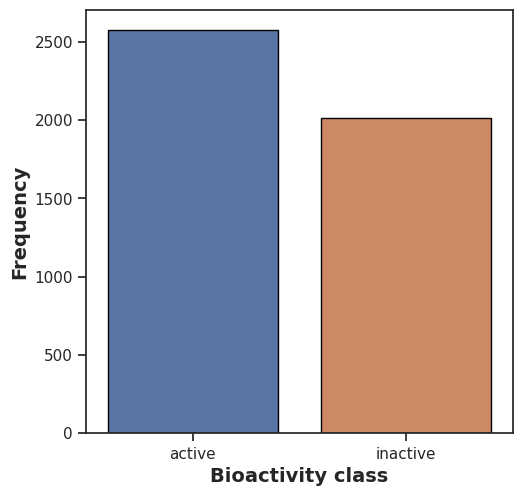

In [ ]:
import seaborn as sns
sns.set(style = 'ticks')
import matplotlib.pyplot as plt

plt.figure(figsize = (5.5, 5.5))
sns.countplot (x = 'class', data = df_2class, edgecolor = 'black')
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.savefig('plot_bioactivity_class.pdf')

In [ ]:
class_counts = df_2class['class'].value_counts()
class_counts

active      2575
inactive    2011
Name: class, dtype: int64

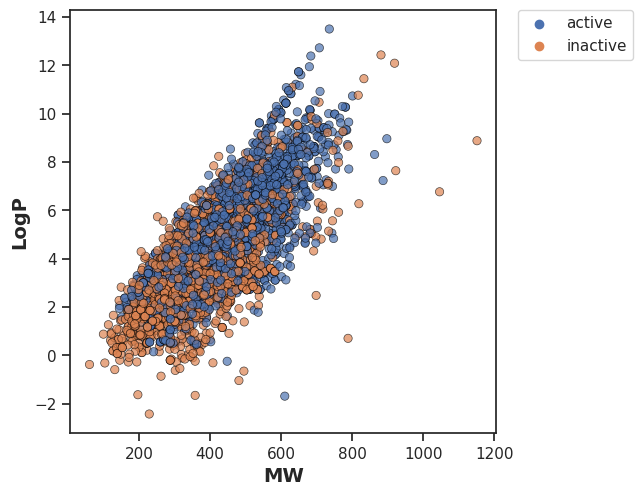

In [ ]:
plt.figure(figsize = (5.5, 5.5))
sns.scatterplot(x = 'MW', y = 'LogP', data = df_2class, hue = 'class', edgecolor = 'black', alpha = 0.7)
plt.xlabel('MW', fontsize = 14, fontweight = 'bold')
plt.ylabel('LogP', fontsize = 14, fontweight = 'bold')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0)
plt.savefig('plot_MV_vs_LogP.pdf')

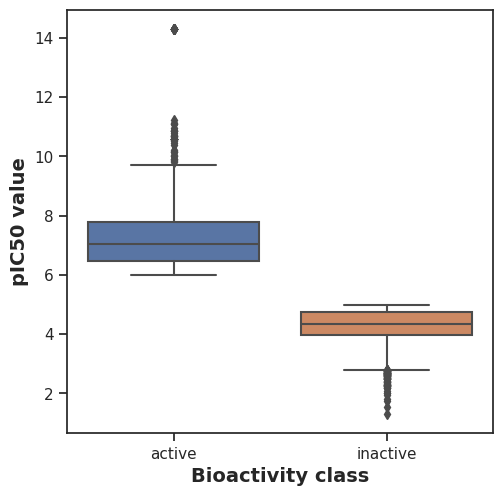

In [ ]:
plt.figure(figsize = (5.5, 5.5))
sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('pIC50 value', fontsize = 14, fontweight = 'bold')
# plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0)
plt.savefig('plot_pIC50.pdf')

In [ ]:
def mannwhitney(descriptor, verbose = False):
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu

    seed(1)

    selection = [descriptor, 'class']
    df = df_2class[selection]
    active = df[df['class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'class']
    df = df_2class[selection]
    inactive = df[df['class'] == 'inactive']
    inactive = inactive[descriptor]

    stat, p = mannwhitneyu(active, inactive)

    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject HO)'
    else:
        interpretation = 'Different distribution (reject HO)'

    results = pd.DataFrame({'Descriptor':descriptor,
                            'Statistics':stat,
                            'p':p,
                            'alpha':alpha,
                            'Interpretation':interpretation}, index = [0])

    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,NaN,NaN,0.05,Different distribution (reject HO)


In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,3362993.5,9.303049e-68,0.05,Different distribution (reject HO)


In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,3512020.5,1.425485e-95,0.05,Different distribution (reject HO)


In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2951271.5,1.289399e-17,0.05,Different distribution (reject HO)


In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,2781192.5,0.000012,0.05,Different distribution (reject HO)


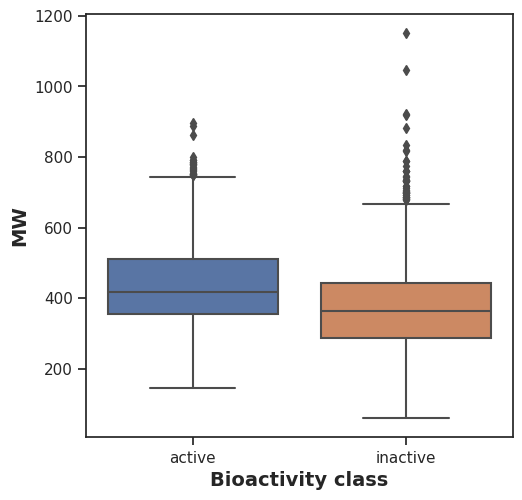

In [ ]:
plt.figure(figsize = (5.5, 5.5))
sns.boxplot(x = 'class', y = 'MW', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('MW', fontsize = 14, fontweight = 'bold')
plt.savefig('plot_MW.pdf')

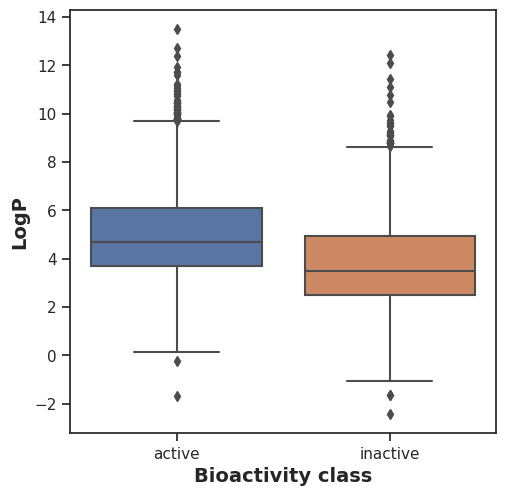

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'class', y = 'LogP', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('LogP', fontsize = 14, fontweight = 'bold')
plt.savefig('plot_LogP.pdf')

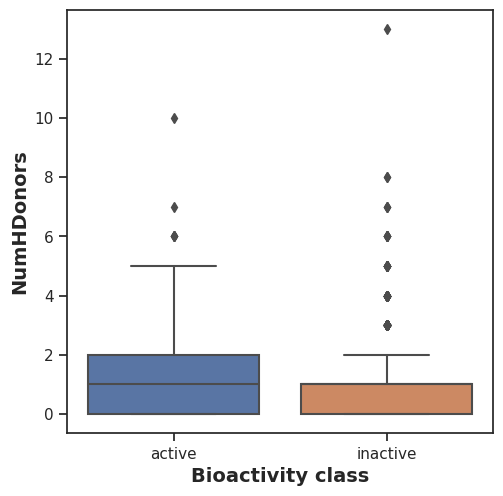

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('NumHDonors', fontsize = 14, fontweight = 'bold')
plt.savefig('plot_NumHDonors.pdf')

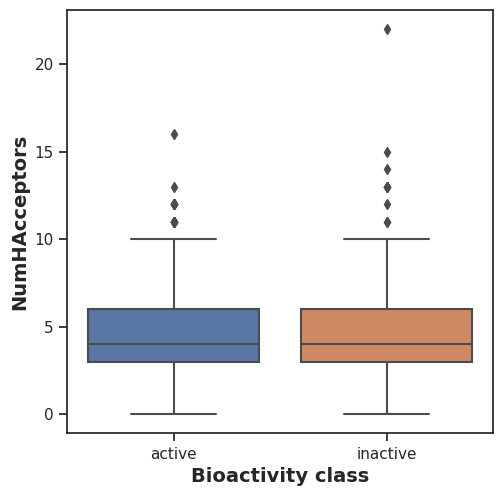

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)
plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('NumHAcceptors', fontsize = 14, fontweight = 'bold')
plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
! zip -r part_2_acetylcholinesterase_results.zip . -i *.csv *.pdf

  adding: plot_MV_vs_LogP.pdf (deflated 7%)
  adding: plot_pIC50.pdf (deflated 35%)
  adding: 04_acetylcholinesterase_bioactivity_data_3classes_pIC50.csv (deflated 77%)
  adding: mannwhitneyu_pIC50.csv (deflated 7%)
  adding: plot_NumHAcceptors.pdf (deflated 39%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: plot_bioactivity_class.pdf (deflated 39%)
  adding: mannwhitneyu_LogP.csv (deflated 9%)
  adding: plot_LogP.pdf (deflated 37%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: plot_MW.pdf (deflated 38%)
  adding: 03_acetylcholinesterase_bioactivity_data_curated.csv (deflated 82%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: 05_acetylcholinesterase_bioativity_data_2classes_pIC50.csv (deflated 76%)
